# MFCC-based CNN Model for Speech Emotion Recognition

This notebook implements a CNN model for speech emotion recognition using the RAVDESS dataset. The model aims to achieve 85.82% accuracy using MFCC features.

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [2]:
def load_ravdess_data(data_path):
    data = []
    for actor in os.listdir(data_path):
        if actor.startswith('Actor'):
            actor_path = os.path.join(data_path, actor)
            for filename in os.listdir(actor_path):
                file_path = os.path.join(actor_path, filename)
                # Parse filename for labels (format: 03-01-01-01-01-01-01.wav)
                parts = filename.split('-')
                emotion = int(parts[2]) - 1  # Convert to 0-based index
                data.append({
                    'path': file_path,
                    'emotion': emotion,
                    'actor': actor
                })
    return pd.DataFrame(data)

def extract_mfcc(file_path, n_mfcc=40):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, duration=3)
        
        # Ensure consistent length
        if len(y) < sr * 3:
            y = np.pad(y, (0, sr * 3 - len(y)))
        else:
            y = y[:sr * 3]
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Load data
data_path = "data/ravdess_actors"
df = load_ravdess_data(data_path)
print(f"Total samples: {len(df)}")
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Total samples: 1440

Emotion distribution:
emotion
1    192
2    192
3    192
4    192
6    192
5    192
7    192
0     96
Name: count, dtype: int64


In [3]:
# Extract MFCC features for all audio files
print("Extracting MFCC features...")
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    mfcc = extract_mfcc(row['path'])
    if mfcc is not None:
        # Transpose MFCC to have time steps as the sequence length
        mfcc = mfcc.T  # Shape becomes (time_steps, n_mfcc)
        X.append(mfcc)
        y.append(row['emotion'])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors and reshape for Conv1d
# Conv1d expects input shape: (batch_size, channels, sequence_length)
# where sequence_length is the time dimension and channels is the number of MFCC coefficients
X_train = torch.FloatTensor(X_train).transpose(1, 2)  # Swap MFCC and time dimensions
X_test = torch.FloatTensor(X_test).transpose(1, 2)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of test samples: {len(y_test)}")

Extracting MFCC features...


100%|██████████| 1440/1440 [00:11<00:00, 124.51it/s]



Features shape: (1440, 130, 40)
Labels shape: (1440,)

Training set shape: torch.Size([1152, 40, 130])
Test set shape: torch.Size([288, 40, 130])
Number of training samples: 1152
Number of test samples: 288


## Model Architecture
Here's the CNN model architecture that achieves 85.82% accuracy using MFCC features:

In [4]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        
        # First Conv1d block
        self.conv1 = nn.Sequential(
            nn.Conv1d(40, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        # Second Conv1d block with residual connection
        self.conv2_1 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding='same'),
            nn.BatchNorm1d(256)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1)  # 1x1 conv for dimension matching
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third Conv1d block with residual connection
        self.conv3_1 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding='same'),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=3, padding='same'),
            nn.BatchNorm1d(512)
        )
        self.conv3_2 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=1)  # 1x1 conv for dimension matching
        )
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.fc_bn = nn.BatchNorm1d(256)
        self.fc_relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        
        # Second block with residual
        identity = x
        x = self.conv2_1(x)
        identity = self.conv2_2(identity)
        x += identity
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block with residual
        identity = x
        x = self.conv3_1(x)
        identity = self.conv3_2(identity)
        x += identity
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.fc_bn(x)
        x = self.fc_relu(x)
        x = self.fc_dropout(x)
        x = self.fc2(x)
        
        return x

# Create the model instance
model = EmotionCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

print(model)

EmotionCNN(
  (conv1): Sequential(
    (0): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv2_1): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  )
  (relu2): ReLU()
  (pool2): Max

## Training Configuration
The model uses the following training parameters:
- Batch size: 16
- Number of epochs: 200
- Learning rate: 0.00005
- Optimizer: RMSprop
- Loss function: CrossEntropyLoss
- Dropout rate: 0.1

In [5]:
# Training parameters
num_epochs = 200
batch_size = 32

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

# Mixup augmentation function
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Mixup criterion
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training loop
train_losses = []
test_accuracies = []
best_accuracy = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    # Training phase
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_X, batch_y in pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Apply mixup
            mixed_X, y_a, y_b, lam = mixup_data(batch_X, batch_y)
            
            optimizer.zero_grad()
            outputs = model(mixed_X)
            
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    val_losses = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    train_losses.append(total_loss / len(train_loader))
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict().copy()
        
        # Store predictions and targets for best epoch
        epoch_predictions = all_predictions
        epoch_targets = all_targets
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {train_losses[-1]:.4f}')
    print(f'Validation Loss: {np.mean(val_losses):.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Best Accuracy: {best_accuracy:.2f}%')
    print('-' * 50)

# Load best model
model.load_state_dict(best_model_state)
print(f'\nFinal Best Accuracy: {best_accuracy:.2f}%')

Epoch 1/200: 100%|██████████| 36/36 [00:01<00:00, 20.86it/s, loss=1.98]



Epoch [1/200]
Training Loss: 2.1112
Validation Loss: 1.8994
Test Accuracy: 22.92%
Best Accuracy: 22.92%
--------------------------------------------------


Epoch 2/200: 100%|██████████| 36/36 [00:00<00:00, 138.25it/s, loss=1.83]



Epoch [2/200]
Training Loss: 1.9340
Validation Loss: 1.6761
Test Accuracy: 32.99%
Best Accuracy: 32.99%
--------------------------------------------------


Epoch 3/200: 100%|██████████| 36/36 [00:00<00:00, 132.30it/s, loss=2.02]



Epoch [3/200]
Training Loss: 1.8262
Validation Loss: 1.5852
Test Accuracy: 39.24%
Best Accuracy: 39.24%
--------------------------------------------------


Epoch 4/200: 100%|██████████| 36/36 [00:00<00:00, 113.77it/s, loss=1.74]



Epoch [4/200]
Training Loss: 1.7405
Validation Loss: 1.4675
Test Accuracy: 44.44%
Best Accuracy: 44.44%
--------------------------------------------------


Epoch 5/200: 100%|██████████| 36/36 [00:00<00:00, 127.03it/s, loss=1.86]



Epoch [5/200]
Training Loss: 1.5776
Validation Loss: 1.4028
Test Accuracy: 45.14%
Best Accuracy: 45.14%
--------------------------------------------------


Epoch 6/200: 100%|██████████| 36/36 [00:00<00:00, 116.60it/s, loss=1.47]



Epoch [6/200]
Training Loss: 1.5074
Validation Loss: 1.3144
Test Accuracy: 49.31%
Best Accuracy: 49.31%
--------------------------------------------------


Epoch 7/200: 100%|██████████| 36/36 [00:00<00:00, 114.79it/s, loss=1.49]



Epoch [7/200]
Training Loss: 1.3937
Validation Loss: 1.4022
Test Accuracy: 48.26%
Best Accuracy: 49.31%
--------------------------------------------------


Epoch 8/200: 100%|██████████| 36/36 [00:00<00:00, 123.69it/s, loss=1.42]



Epoch [8/200]
Training Loss: 1.3616
Validation Loss: 1.4746
Test Accuracy: 47.92%
Best Accuracy: 49.31%
--------------------------------------------------


Epoch 9/200: 100%|██████████| 36/36 [00:00<00:00, 117.23it/s, loss=1.01] 



Epoch [9/200]
Training Loss: 1.2748
Validation Loss: 1.1997
Test Accuracy: 54.51%
Best Accuracy: 54.51%
--------------------------------------------------


Epoch 10/200: 100%|██████████| 36/36 [00:00<00:00, 109.61it/s, loss=1.27]



Epoch [10/200]
Training Loss: 1.2539
Validation Loss: 1.3929
Test Accuracy: 44.79%
Best Accuracy: 54.51%
--------------------------------------------------


Epoch 11/200: 100%|██████████| 36/36 [00:00<00:00, 128.06it/s, loss=1.55] 


Epoch [11/200]
Training Loss: 1.2313
Validation Loss: 1.2723
Test Accuracy: 53.12%
Best Accuracy: 54.51%
--------------------------------------------------


Epoch 12/200: 100%|██████████| 36/36 [00:00<00:00, 115.65it/s, loss=1.53] 



Epoch [12/200]
Training Loss: 1.1419
Validation Loss: 1.0162
Test Accuracy: 64.24%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 13/200: 100%|██████████| 36/36 [00:00<00:00, 114.44it/s, loss=0.775]



Epoch [13/200]
Training Loss: 1.0489
Validation Loss: 1.2579
Test Accuracy: 59.72%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 14/200: 100%|██████████| 36/36 [00:00<00:00, 119.41it/s, loss=0.883]



Epoch [14/200]
Training Loss: 1.0577
Validation Loss: 1.6165
Test Accuracy: 46.18%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 15/200: 100%|██████████| 36/36 [00:00<00:00, 125.92it/s, loss=1.79] 



Epoch [15/200]
Training Loss: 1.0645
Validation Loss: 1.2586
Test Accuracy: 56.94%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 16/200: 100%|██████████| 36/36 [00:00<00:00, 123.38it/s, loss=0.686]



Epoch [16/200]
Training Loss: 0.9529
Validation Loss: 1.0950
Test Accuracy: 60.07%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 17/200: 100%|██████████| 36/36 [00:00<00:00, 126.56it/s, loss=0.844]



Epoch [17/200]
Training Loss: 0.9632
Validation Loss: 1.2690
Test Accuracy: 60.76%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 18/200: 100%|██████████| 36/36 [00:00<00:00, 126.55it/s, loss=1.54] 



Epoch [18/200]
Training Loss: 1.0050
Validation Loss: 1.1885
Test Accuracy: 62.15%
Best Accuracy: 64.24%
--------------------------------------------------


Epoch 19/200: 100%|██████████| 36/36 [00:00<00:00, 126.13it/s, loss=0.479]


Epoch [19/200]
Training Loss: 0.8855
Validation Loss: 0.9357
Test Accuracy: 70.83%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 20/200: 100%|██████████| 36/36 [00:00<00:00, 118.92it/s, loss=0.524]



Epoch [20/200]
Training Loss: 1.0738
Validation Loss: 1.3043
Test Accuracy: 55.21%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 21/200: 100%|██████████| 36/36 [00:00<00:00, 110.12it/s, loss=0.932]



Epoch [21/200]
Training Loss: 0.8394
Validation Loss: 1.0054
Test Accuracy: 65.28%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 22/200: 100%|██████████| 36/36 [00:00<00:00, 126.53it/s, loss=0.397]



Epoch [22/200]
Training Loss: 0.7997
Validation Loss: 2.0105
Test Accuracy: 40.28%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 23/200: 100%|██████████| 36/36 [00:00<00:00, 115.76it/s, loss=1.81] 



Epoch [23/200]
Training Loss: 0.7819
Validation Loss: 1.6401
Test Accuracy: 55.90%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 24/200: 100%|██████████| 36/36 [00:00<00:00, 125.05it/s, loss=0.676]



Epoch [24/200]
Training Loss: 0.7478
Validation Loss: 0.9383
Test Accuracy: 70.83%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 25/200: 100%|██████████| 36/36 [00:00<00:00, 133.33it/s, loss=1.1]  



Epoch [25/200]
Training Loss: 0.8436
Validation Loss: 0.9316
Test Accuracy: 67.36%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 26/200: 100%|██████████| 36/36 [00:00<00:00, 131.42it/s, loss=0.277]



Epoch [26/200]
Training Loss: 0.7460
Validation Loss: 1.4869
Test Accuracy: 57.29%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 27/200: 100%|██████████| 36/36 [00:00<00:00, 130.33it/s, loss=0.491]



Epoch [27/200]
Training Loss: 0.6643
Validation Loss: 1.2826
Test Accuracy: 58.33%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 28/200: 100%|██████████| 36/36 [00:00<00:00, 115.27it/s, loss=0.292]



Epoch [28/200]
Training Loss: 0.7294
Validation Loss: 1.5346
Test Accuracy: 57.99%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 29/200: 100%|██████████| 36/36 [00:00<00:00, 129.98it/s, loss=0.451]



Epoch [29/200]
Training Loss: 0.7191
Validation Loss: 1.0231
Test Accuracy: 67.71%
Best Accuracy: 70.83%
--------------------------------------------------


Epoch 30/200: 100%|██████████| 36/36 [00:00<00:00, 126.99it/s, loss=1.29] 



Epoch [30/200]
Training Loss: 0.7442
Validation Loss: 0.7383
Test Accuracy: 75.69%
Best Accuracy: 75.69%
--------------------------------------------------


Epoch 31/200: 100%|██████████| 36/36 [00:00<00:00, 133.31it/s, loss=0.469]


Epoch [31/200]
Training Loss: 0.5828
Validation Loss: 1.1601
Test Accuracy: 63.89%
Best Accuracy: 75.69%
--------------------------------------------------


Epoch 32/200: 100%|██████████| 36/36 [00:00<00:00, 130.17it/s, loss=0.283] 



Epoch [32/200]
Training Loss: 0.5925
Validation Loss: 0.7940
Test Accuracy: 72.92%
Best Accuracy: 75.69%
--------------------------------------------------


Epoch 33/200: 100%|██████████| 36/36 [00:00<00:00, 127.28it/s, loss=0.398]


Epoch [33/200]
Training Loss: 0.6523
Validation Loss: 0.6605
Test Accuracy: 78.47%
Best Accuracy: 78.47%
--------------------------------------------------


Epoch 34/200: 100%|██████████| 36/36 [00:00<00:00, 125.42it/s, loss=0.487]



Epoch [34/200]
Training Loss: 0.7913
Validation Loss: 0.8126
Test Accuracy: 76.04%
Best Accuracy: 78.47%
--------------------------------------------------


Epoch 35/200: 100%|██████████| 36/36 [00:00<00:00, 101.55it/s, loss=0.198]



Epoch [35/200]
Training Loss: 0.6689
Validation Loss: 1.2004
Test Accuracy: 64.58%
Best Accuracy: 78.47%
--------------------------------------------------


Epoch 36/200: 100%|██████████| 36/36 [00:00<00:00, 119.65it/s, loss=0.759]


Epoch [36/200]
Training Loss: 0.6248
Validation Loss: 0.8293
Test Accuracy: 72.92%
Best Accuracy: 78.47%
--------------------------------------------------


Epoch 37/200: 100%|██████████| 36/36 [00:00<00:00, 123.19it/s, loss=0.304]



Epoch [37/200]
Training Loss: 0.5175
Validation Loss: 0.6002
Test Accuracy: 81.94%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 38/200: 100%|██████████| 36/36 [00:00<00:00, 124.64it/s, loss=0.3]   



Epoch [38/200]
Training Loss: 0.4225
Validation Loss: 0.6825
Test Accuracy: 78.12%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 39/200: 100%|██████████| 36/36 [00:00<00:00, 123.88it/s, loss=0.682] 



Epoch [39/200]
Training Loss: 0.5787
Validation Loss: 0.6596
Test Accuracy: 78.12%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 40/200: 100%|██████████| 36/36 [00:00<00:00, 121.07it/s, loss=0.71] 



Epoch [40/200]
Training Loss: 0.6380
Validation Loss: 0.9027
Test Accuracy: 68.40%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 41/200: 100%|██████████| 36/36 [00:00<00:00, 117.57it/s, loss=0.14] 


Epoch [41/200]
Training Loss: 0.6640
Validation Loss: 0.7510
Test Accuracy: 76.74%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 42/200: 100%|██████████| 36/36 [00:00<00:00, 115.91it/s, loss=1.82]  



Epoch [42/200]
Training Loss: 0.6437
Validation Loss: 0.6802
Test Accuracy: 78.47%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 43/200: 100%|██████████| 36/36 [00:00<00:00, 118.55it/s, loss=1.37]  



Epoch [43/200]
Training Loss: 0.7837
Validation Loss: 0.9095
Test Accuracy: 73.26%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 44/200: 100%|██████████| 36/36 [00:00<00:00, 131.50it/s, loss=0.0849]



Epoch [44/200]
Training Loss: 0.5346
Validation Loss: 0.7103
Test Accuracy: 75.69%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 45/200: 100%|██████████| 36/36 [00:00<00:00, 130.66it/s, loss=0.12]


Epoch [45/200]
Training Loss: 0.6945
Validation Loss: 0.6130
Test Accuracy: 79.51%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 46/200: 100%|██████████| 36/36 [00:00<00:00, 132.89it/s, loss=2.05]  



Epoch [46/200]
Training Loss: 0.6948
Validation Loss: 0.6766
Test Accuracy: 77.78%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 47/200: 100%|██████████| 36/36 [00:00<00:00, 130.81it/s, loss=0.399] 



Epoch [47/200]
Training Loss: 0.4457
Validation Loss: 0.9730
Test Accuracy: 68.06%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 48/200: 100%|██████████| 36/36 [00:00<00:00, 115.29it/s, loss=1.29]  



Epoch [48/200]
Training Loss: 0.5624
Validation Loss: 0.8125
Test Accuracy: 75.35%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 49/200: 100%|██████████| 36/36 [00:00<00:00, 119.27it/s, loss=0.128] 



Epoch [49/200]
Training Loss: 0.5178
Validation Loss: 0.6172
Test Accuracy: 80.56%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 50/200: 100%|██████████| 36/36 [00:00<00:00, 120.40it/s, loss=0.167]



Epoch [50/200]
Training Loss: 0.5869
Validation Loss: 0.7935
Test Accuracy: 73.96%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 51/200: 100%|██████████| 36/36 [00:00<00:00, 119.03it/s, loss=0.608]



Epoch [51/200]
Training Loss: 0.5195
Validation Loss: 0.7448
Test Accuracy: 77.08%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 52/200: 100%|██████████| 36/36 [00:00<00:00, 121.77it/s, loss=0.0823]


Epoch [52/200]
Training Loss: 0.4597
Validation Loss: 0.6290
Test Accuracy: 77.08%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 53/200: 100%|██████████| 36/36 [00:00<00:00, 117.04it/s, loss=0.412] 



Epoch [53/200]
Training Loss: 0.5425
Validation Loss: 0.9900
Test Accuracy: 67.71%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 54/200: 100%|██████████| 36/36 [00:00<00:00, 112.86it/s, loss=1.07] 



Epoch [54/200]
Training Loss: 0.5997
Validation Loss: 0.6484
Test Accuracy: 78.47%
Best Accuracy: 81.94%
--------------------------------------------------


Epoch 55/200: 100%|██████████| 36/36 [00:00<00:00, 116.92it/s, loss=0.104] 



Epoch [55/200]
Training Loss: 0.5436
Validation Loss: 0.5560
Test Accuracy: 83.33%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 56/200: 100%|██████████| 36/36 [00:00<00:00, 119.05it/s, loss=0.151] 



Epoch [56/200]
Training Loss: 0.5636
Validation Loss: 0.9529
Test Accuracy: 70.14%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 57/200: 100%|██████████| 36/36 [00:00<00:00, 119.74it/s, loss=0.102]



Epoch [57/200]
Training Loss: 0.6080
Validation Loss: 0.6921
Test Accuracy: 76.74%
Best Accuracy: 83.33%
--------------------------------------------------


Epoch 58/200: 100%|██████████| 36/36 [00:00<00:00, 117.66it/s, loss=0.139] 



Epoch [58/200]
Training Loss: 0.5372
Validation Loss: 0.5201
Test Accuracy: 84.72%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 59/200: 100%|██████████| 36/36 [00:00<00:00, 119.54it/s, loss=0.0722]



Epoch [59/200]
Training Loss: 0.5801
Validation Loss: 0.5329
Test Accuracy: 83.33%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 60/200: 100%|██████████| 36/36 [00:00<00:00, 106.24it/s, loss=0.921] 



Epoch [60/200]
Training Loss: 0.6393
Validation Loss: 0.7872
Test Accuracy: 73.61%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 61/200: 100%|██████████| 36/36 [00:00<00:00, 110.41it/s, loss=0.0859]



Epoch [61/200]
Training Loss: 0.6190
Validation Loss: 0.7257
Test Accuracy: 77.43%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 62/200: 100%|██████████| 36/36 [00:00<00:00, 121.42it/s, loss=1.43]  



Epoch [62/200]
Training Loss: 0.5982
Validation Loss: 0.5806
Test Accuracy: 84.03%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 63/200: 100%|██████████| 36/36 [00:00<00:00, 122.76it/s, loss=1.69]  



Epoch [63/200]
Training Loss: 0.5593
Validation Loss: 0.5704
Test Accuracy: 82.29%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 64/200: 100%|██████████| 36/36 [00:00<00:00, 120.10it/s, loss=1.36]  



Epoch [64/200]
Training Loss: 0.4934
Validation Loss: 0.8953
Test Accuracy: 71.53%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 65/200: 100%|██████████| 36/36 [00:00<00:00, 111.10it/s, loss=0.0396]



Epoch [65/200]
Training Loss: 0.2741
Validation Loss: 0.5546
Test Accuracy: 83.33%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 66/200: 100%|██████████| 36/36 [00:00<00:00, 98.46it/s, loss=0.0863]



Epoch [66/200]
Training Loss: 0.5825
Validation Loss: 0.7387
Test Accuracy: 74.65%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 67/200: 100%|██████████| 36/36 [00:00<00:00, 115.98it/s, loss=0.577] 



Epoch [67/200]
Training Loss: 0.6635
Validation Loss: 0.7035
Test Accuracy: 76.04%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 68/200: 100%|██████████| 36/36 [00:00<00:00, 107.40it/s, loss=0.118] 



Epoch [68/200]
Training Loss: 0.4153
Validation Loss: 0.5484
Test Accuracy: 81.60%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 69/200: 100%|██████████| 36/36 [00:00<00:00, 122.16it/s, loss=0.317] 



Epoch [69/200]
Training Loss: 0.4445
Validation Loss: 0.5731
Test Accuracy: 82.64%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 70/200: 100%|██████████| 36/36 [00:00<00:00, 119.08it/s, loss=0.146]


Epoch [70/200]
Training Loss: 0.3997
Validation Loss: 0.4963
Test Accuracy: 83.68%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 71/200: 100%|██████████| 36/36 [00:00<00:00, 114.95it/s, loss=0.901] 



Epoch [71/200]
Training Loss: 0.5272
Validation Loss: 0.5306
Test Accuracy: 82.29%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 72/200: 100%|██████████| 36/36 [00:00<00:00, 111.13it/s, loss=1.1]   



Epoch [72/200]
Training Loss: 0.4275
Validation Loss: 0.5951
Test Accuracy: 81.60%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 73/200: 100%|██████████| 36/36 [00:00<00:00, 123.51it/s, loss=0.0562]


Epoch [73/200]
Training Loss: 0.3766
Validation Loss: 0.6393
Test Accuracy: 78.82%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 74/200: 100%|██████████| 36/36 [00:00<00:00, 113.15it/s, loss=1.6]   



Epoch [74/200]
Training Loss: 0.6371
Validation Loss: 0.6472
Test Accuracy: 79.51%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 75/200: 100%|██████████| 36/36 [00:00<00:00, 125.53it/s, loss=0.369]


Epoch [75/200]
Training Loss: 0.7019
Validation Loss: 0.6099
Test Accuracy: 81.94%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 76/200: 100%|██████████| 36/36 [00:00<00:00, 126.04it/s, loss=1.25] 


Epoch [76/200]
Training Loss: 0.4272
Validation Loss: 0.5741
Test Accuracy: 82.99%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 77/200: 100%|██████████| 36/36 [00:00<00:00, 123.60it/s, loss=0.0561]



Epoch [77/200]
Training Loss: 0.3205
Validation Loss: 0.5465
Test Accuracy: 83.33%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 78/200: 100%|██████████| 36/36 [00:00<00:00, 124.72it/s, loss=0.467] 



Epoch [78/200]
Training Loss: 0.6266
Validation Loss: 0.5699
Test Accuracy: 82.64%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 79/200: 100%|██████████| 36/36 [00:00<00:00, 113.37it/s, loss=0.201] 



Epoch [79/200]
Training Loss: 0.4921
Validation Loss: 0.7817
Test Accuracy: 74.65%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 80/200: 100%|██████████| 36/36 [00:00<00:00, 126.41it/s, loss=0.0764]



Epoch [80/200]
Training Loss: 0.3605
Validation Loss: 0.6382
Test Accuracy: 78.12%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 81/200: 100%|██████████| 36/36 [00:00<00:00, 126.02it/s, loss=0.0701]



Epoch [81/200]
Training Loss: 0.4734
Validation Loss: 0.6075
Test Accuracy: 79.51%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 82/200: 100%|██████████| 36/36 [00:00<00:00, 126.98it/s, loss=0.0969]



Epoch [82/200]
Training Loss: 0.4751
Validation Loss: 0.8249
Test Accuracy: 77.08%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 83/200: 100%|██████████| 36/36 [00:00<00:00, 125.62it/s, loss=0.0448]



Epoch [83/200]
Training Loss: 0.5236
Validation Loss: 0.5823
Test Accuracy: 82.64%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 84/200: 100%|██████████| 36/36 [00:00<00:00, 122.26it/s, loss=1.33]  



Epoch [84/200]
Training Loss: 0.4763
Validation Loss: 0.7393
Test Accuracy: 74.31%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 85/200: 100%|██████████| 36/36 [00:00<00:00, 95.11it/s, loss=0.0587]



Epoch [85/200]
Training Loss: 0.5390
Validation Loss: 0.5832
Test Accuracy: 81.94%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 86/200: 100%|██████████| 36/36 [00:00<00:00, 116.56it/s, loss=0.121] 



Epoch [86/200]
Training Loss: 0.3773
Validation Loss: 0.5627
Test Accuracy: 81.94%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 87/200: 100%|██████████| 36/36 [00:00<00:00, 113.67it/s, loss=0.945] 



Epoch [87/200]
Training Loss: 0.4488
Validation Loss: 0.5860
Test Accuracy: 81.94%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 88/200: 100%|██████████| 36/36 [00:00<00:00, 118.28it/s, loss=0.263] 



Epoch [88/200]
Training Loss: 0.4697
Validation Loss: 0.5799
Test Accuracy: 81.60%
Best Accuracy: 84.72%
--------------------------------------------------


Epoch 89/200: 100%|██████████| 36/36 [00:00<00:00, 124.73it/s, loss=0.878] 



Epoch [89/200]
Training Loss: 0.5983
Validation Loss: 0.5280
Test Accuracy: 85.42%
Best Accuracy: 85.42%
--------------------------------------------------


Epoch 90/200: 100%|██████████| 36/36 [00:00<00:00, 98.07it/s, loss=0.491]  



Epoch [90/200]
Training Loss: 0.3189
Validation Loss: 0.5434
Test Accuracy: 82.64%
Best Accuracy: 85.42%
--------------------------------------------------


Epoch 91/200: 100%|██████████| 36/36 [00:00<00:00, 111.58it/s, loss=0.803] 



Epoch [91/200]
Training Loss: 0.4844
Validation Loss: 0.4992
Test Accuracy: 85.76%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 92/200: 100%|██████████| 36/36 [00:00<00:00, 124.19it/s, loss=0.0714]



Epoch [92/200]
Training Loss: 0.3712
Validation Loss: 0.5244
Test Accuracy: 81.94%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 93/200: 100%|██████████| 36/36 [00:00<00:00, 123.95it/s, loss=0.048]


Epoch [93/200]
Training Loss: 0.5119
Validation Loss: 0.6026
Test Accuracy: 82.29%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 94/200: 100%|██████████| 36/36 [00:00<00:00, 118.22it/s, loss=1.17]  



Epoch [94/200]
Training Loss: 0.4952
Validation Loss: 0.6016
Test Accuracy: 80.90%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 95/200: 100%|██████████| 36/36 [00:00<00:00, 97.61it/s, loss=1.26]   



Epoch [95/200]
Training Loss: 0.3714
Validation Loss: 0.4812
Test Accuracy: 84.72%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 96/200: 100%|██████████| 36/36 [00:00<00:00, 117.07it/s, loss=0.648] 



Epoch [96/200]
Training Loss: 0.4083
Validation Loss: 0.5046
Test Accuracy: 83.33%
Best Accuracy: 85.76%
--------------------------------------------------


Epoch 97/200: 100%|██████████| 36/36 [00:00<00:00, 119.50it/s, loss=1.26]  



Epoch [97/200]
Training Loss: 0.3398
Validation Loss: 0.4532
Test Accuracy: 86.81%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 98/200: 100%|██████████| 36/36 [00:00<00:00, 123.85it/s, loss=0.0559]



Epoch [98/200]
Training Loss: 0.4450
Validation Loss: 0.5340
Test Accuracy: 83.33%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 99/200: 100%|██████████| 36/36 [00:00<00:00, 120.01it/s, loss=0.917] 



Epoch [99/200]
Training Loss: 0.5590
Validation Loss: 0.5182
Test Accuracy: 83.33%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 100/200: 100%|██████████| 36/36 [00:00<00:00, 108.01it/s, loss=1.19] 


Epoch [100/200]
Training Loss: 0.5911
Validation Loss: 0.5272
Test Accuracy: 84.38%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 101/200: 100%|██████████| 36/36 [00:00<00:00, 117.65it/s, loss=0.46]  



Epoch [101/200]
Training Loss: 0.4121
Validation Loss: 0.5059
Test Accuracy: 82.99%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 102/200: 100%|██████████| 36/36 [00:00<00:00, 115.91it/s, loss=1.03]  



Epoch [102/200]
Training Loss: 0.5465
Validation Loss: 0.4944
Test Accuracy: 83.68%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 103/200: 100%|██████████| 36/36 [00:00<00:00, 116.32it/s, loss=0.0742]



Epoch [103/200]
Training Loss: 0.2431
Validation Loss: 0.4902
Test Accuracy: 84.38%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 104/200: 100%|██████████| 36/36 [00:00<00:00, 120.29it/s, loss=0.0305]



Epoch [104/200]
Training Loss: 0.3930
Validation Loss: 0.5188
Test Accuracy: 83.68%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 105/200: 100%|██████████| 36/36 [00:00<00:00, 102.01it/s, loss=0.0503]



Epoch [105/200]
Training Loss: 0.3716
Validation Loss: 0.4877
Test Accuracy: 86.46%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 106/200: 100%|██████████| 36/36 [00:00<00:00, 116.15it/s, loss=1.28]  



Epoch [106/200]
Training Loss: 0.4321
Validation Loss: 0.4879
Test Accuracy: 84.72%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 107/200: 100%|██████████| 36/36 [00:00<00:00, 120.10it/s, loss=0.0426]



Epoch [107/200]
Training Loss: 0.3979
Validation Loss: 0.4777
Test Accuracy: 86.11%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 108/200: 100%|██████████| 36/36 [00:00<00:00, 115.79it/s, loss=0.0806]



Epoch [108/200]
Training Loss: 0.5852
Validation Loss: 0.4947
Test Accuracy: 86.46%
Best Accuracy: 86.81%
--------------------------------------------------


Epoch 109/200: 100%|██████████| 36/36 [00:00<00:00, 116.73it/s, loss=0.103] 



Epoch [109/200]
Training Loss: 0.3575
Validation Loss: 0.4595
Test Accuracy: 87.50%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 110/200: 100%|██████████| 36/36 [00:00<00:00, 101.74it/s, loss=0.0452]



Epoch [110/200]
Training Loss: 0.3670
Validation Loss: 0.4667
Test Accuracy: 85.42%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 111/200: 100%|██████████| 36/36 [00:00<00:00, 113.89it/s, loss=0.0521]



Epoch [111/200]
Training Loss: 0.4082
Validation Loss: 0.5046
Test Accuracy: 84.72%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 112/200: 100%|██████████| 36/36 [00:00<00:00, 110.30it/s, loss=0.15]  



Epoch [112/200]
Training Loss: 0.4518
Validation Loss: 0.5114
Test Accuracy: 85.76%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 113/200: 100%|██████████| 36/36 [00:00<00:00, 118.63it/s, loss=0.262] 



Epoch [113/200]
Training Loss: 0.3427
Validation Loss: 0.5368
Test Accuracy: 82.99%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 114/200: 100%|██████████| 36/36 [00:00<00:00, 110.50it/s, loss=0.0728]



Epoch [114/200]
Training Loss: 0.5915
Validation Loss: 0.4770
Test Accuracy: 85.07%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 115/200: 100%|██████████| 36/36 [00:00<00:00, 107.77it/s, loss=0.051]



Epoch [115/200]
Training Loss: 0.4275
Validation Loss: 0.5166
Test Accuracy: 82.64%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 116/200: 100%|██████████| 36/36 [00:00<00:00, 107.51it/s, loss=0.105] 



Epoch [116/200]
Training Loss: 0.4457
Validation Loss: 0.5011
Test Accuracy: 82.64%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 117/200: 100%|██████████| 36/36 [00:00<00:00, 118.40it/s, loss=1.59]  



Epoch [117/200]
Training Loss: 0.4443
Validation Loss: 0.4686
Test Accuracy: 84.72%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 118/200: 100%|██████████| 36/36 [00:00<00:00, 121.07it/s, loss=0.803] 



Epoch [118/200]
Training Loss: 0.4057
Validation Loss: 0.4969
Test Accuracy: 84.38%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 119/200: 100%|██████████| 36/36 [00:00<00:00, 108.22it/s, loss=1.06]  



Epoch [119/200]
Training Loss: 0.4770
Validation Loss: 0.4480
Test Accuracy: 85.76%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 120/200: 100%|██████████| 36/36 [00:00<00:00, 111.29it/s, loss=0.48]  



Epoch [120/200]
Training Loss: 0.5420
Validation Loss: 0.4981
Test Accuracy: 85.42%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 121/200: 100%|██████████| 36/36 [00:00<00:00, 120.89it/s, loss=0.0983]



Epoch [121/200]
Training Loss: 0.3878
Validation Loss: 0.4524
Test Accuracy: 85.07%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 122/200: 100%|██████████| 36/36 [00:00<00:00, 106.34it/s, loss=0.153] 



Epoch [122/200]
Training Loss: 0.4789
Validation Loss: 0.4822
Test Accuracy: 86.11%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 123/200: 100%|██████████| 36/36 [00:00<00:00, 107.44it/s, loss=1.25]  



Epoch [123/200]
Training Loss: 0.4345
Validation Loss: 0.4355
Test Accuracy: 87.15%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 124/200: 100%|██████████| 36/36 [00:00<00:00, 117.64it/s, loss=0.078]


Epoch [124/200]
Training Loss: 0.5145
Validation Loss: 0.4938
Test Accuracy: 86.11%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 125/200: 100%|██████████| 36/36 [00:00<00:00, 116.63it/s, loss=0.1]


Epoch [125/200]
Training Loss: 0.4430
Validation Loss: 0.4792
Test Accuracy: 83.68%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 126/200: 100%|██████████| 36/36 [00:00<00:00, 105.14it/s, loss=0.0778]



Epoch [126/200]
Training Loss: 0.3443
Validation Loss: 0.4733
Test Accuracy: 86.11%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 127/200: 100%|██████████| 36/36 [00:00<00:00, 120.94it/s, loss=1.49]  



Epoch [127/200]
Training Loss: 0.4680
Validation Loss: 0.4758
Test Accuracy: 85.76%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 128/200: 100%|██████████| 36/36 [00:00<00:00, 106.52it/s, loss=0.0462]



Epoch [128/200]
Training Loss: 0.5293
Validation Loss: 0.5388
Test Accuracy: 85.07%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 129/200: 100%|██████████| 36/36 [00:00<00:00, 113.74it/s, loss=0.0664]



Epoch [129/200]
Training Loss: 0.4416
Validation Loss: 0.4847
Test Accuracy: 83.68%
Best Accuracy: 87.50%
--------------------------------------------------


Epoch 130/200: 100%|██████████| 36/36 [00:00<00:00, 101.71it/s, loss=0.391]


Epoch [130/200]
Training Loss: 0.4263
Validation Loss: 0.4453
Test Accuracy: 88.19%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 131/200: 100%|██████████| 36/36 [00:00<00:00, 120.14it/s, loss=0.584] 



Epoch [131/200]
Training Loss: 0.5517
Validation Loss: 0.4993
Test Accuracy: 84.38%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 132/200: 100%|██████████| 36/36 [00:00<00:00, 119.33it/s, loss=0.0382]



Epoch [132/200]
Training Loss: 0.3349
Validation Loss: 0.4708
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 133/200: 100%|██████████| 36/36 [00:00<00:00, 119.72it/s, loss=1.39]  



Epoch [133/200]
Training Loss: 0.5877
Validation Loss: 0.4298
Test Accuracy: 87.15%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 134/200: 100%|██████████| 36/36 [00:00<00:00, 111.36it/s, loss=1.45]  



Epoch [134/200]
Training Loss: 0.3581
Validation Loss: 0.4692
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 135/200: 100%|██████████| 36/36 [00:00<00:00, 102.27it/s, loss=0.0403]


Epoch [135/200]
Training Loss: 0.3896
Validation Loss: 0.4604
Test Accuracy: 85.42%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 136/200: 100%|██████████| 36/36 [00:00<00:00, 104.09it/s, loss=0.0689]



Epoch [136/200]
Training Loss: 0.6471
Validation Loss: 0.4530
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 137/200: 100%|██████████| 36/36 [00:00<00:00, 110.45it/s, loss=0.0533]



Epoch [137/200]
Training Loss: 0.4752
Validation Loss: 0.4680
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 138/200: 100%|██████████| 36/36 [00:00<00:00, 103.26it/s, loss=1.3]   



Epoch [138/200]
Training Loss: 0.3547
Validation Loss: 0.4401
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 139/200: 100%|██████████| 36/36 [00:00<00:00, 111.25it/s, loss=0.057] 



Epoch [139/200]
Training Loss: 0.5438
Validation Loss: 0.4944
Test Accuracy: 84.03%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 140/200: 100%|██████████| 36/36 [00:00<00:00, 98.71it/s, loss=0.0485] 



Epoch [140/200]
Training Loss: 0.4550
Validation Loss: 0.4727
Test Accuracy: 84.03%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 141/200: 100%|██████████| 36/36 [00:00<00:00, 104.86it/s, loss=0.717] 



Epoch [141/200]
Training Loss: 0.5987
Validation Loss: 0.5188
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 142/200: 100%|██████████| 36/36 [00:00<00:00, 100.79it/s, loss=0.0672]



Epoch [142/200]
Training Loss: 0.4077
Validation Loss: 0.4905
Test Accuracy: 84.03%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 143/200: 100%|██████████| 36/36 [00:00<00:00, 107.11it/s, loss=1.03]  



Epoch [143/200]
Training Loss: 0.4181
Validation Loss: 0.4729
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 144/200: 100%|██████████| 36/36 [00:00<00:00, 105.49it/s, loss=0.545] 



Epoch [144/200]
Training Loss: 0.3911
Validation Loss: 0.4731
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 145/200: 100%|██████████| 36/36 [00:00<00:00, 108.47it/s, loss=0.0699]


Epoch [145/200]
Training Loss: 0.3717
Validation Loss: 0.4581
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 146/200: 100%|██████████| 36/36 [00:00<00:00, 93.59it/s, loss=1.18]  



Epoch [146/200]
Training Loss: 0.3926
Validation Loss: 0.4766
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 147/200: 100%|██████████| 36/36 [00:00<00:00, 97.16it/s, loss=0.423] 



Epoch [147/200]
Training Loss: 0.4634
Validation Loss: 0.4918
Test Accuracy: 84.03%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 148/200: 100%|██████████| 36/36 [00:00<00:00, 106.72it/s, loss=0.179] 



Epoch [148/200]
Training Loss: 0.3048
Validation Loss: 0.4537
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 149/200: 100%|██████████| 36/36 [00:00<00:00, 90.92it/s, loss=0.0593]



Epoch [149/200]
Training Loss: 0.4302
Validation Loss: 0.4582
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 150/200: 100%|██████████| 36/36 [00:00<00:00, 105.44it/s, loss=0.0732]



Epoch [150/200]
Training Loss: 0.4591
Validation Loss: 0.4695
Test Accuracy: 85.42%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 151/200: 100%|██████████| 36/36 [00:00<00:00, 111.64it/s, loss=0.315] 



Epoch [151/200]
Training Loss: 0.2420
Validation Loss: 0.4858
Test Accuracy: 83.68%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 152/200: 100%|██████████| 36/36 [00:00<00:00, 91.47it/s, loss=0.15]  



Epoch [152/200]
Training Loss: 0.3612
Validation Loss: 0.4917
Test Accuracy: 84.03%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 153/200: 100%|██████████| 36/36 [00:00<00:00, 105.22it/s, loss=1.27]  



Epoch [153/200]
Training Loss: 0.3670
Validation Loss: 0.4713
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 154/200: 100%|██████████| 36/36 [00:00<00:00, 104.62it/s, loss=0.108] 



Epoch [154/200]
Training Loss: 0.4399
Validation Loss: 0.4532
Test Accuracy: 85.42%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 155/200: 100%|██████████| 36/36 [00:00<00:00, 98.05it/s, loss=0.989]  



Epoch [155/200]
Training Loss: 0.5658
Validation Loss: 0.4637
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 156/200: 100%|██████████| 36/36 [00:00<00:00, 98.31it/s, loss=1.21]  



Epoch [156/200]
Training Loss: 0.3582
Validation Loss: 0.4724
Test Accuracy: 83.68%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 157/200: 100%|██████████| 36/36 [00:00<00:00, 105.49it/s, loss=0.0566]



Epoch [157/200]
Training Loss: 0.3513
Validation Loss: 0.4462
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 158/200: 100%|██████████| 36/36 [00:00<00:00, 97.32it/s, loss=1.25]  



Epoch [158/200]
Training Loss: 0.4347
Validation Loss: 0.4327
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 159/200: 100%|██████████| 36/36 [00:00<00:00, 99.68it/s, loss=0.0414] 



Epoch [159/200]
Training Loss: 0.3898
Validation Loss: 0.4585
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 160/200: 100%|██████████| 36/36 [00:00<00:00, 115.72it/s, loss=0.266] 



Epoch [160/200]
Training Loss: 0.2836
Validation Loss: 0.4796
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 161/200: 100%|██████████| 36/36 [00:00<00:00, 107.51it/s, loss=1.33]  



Epoch [161/200]
Training Loss: 0.4463
Validation Loss: 0.4467
Test Accuracy: 87.50%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 162/200: 100%|██████████| 36/36 [00:00<00:00, 112.89it/s, loss=0.0833]



Epoch [162/200]
Training Loss: 0.3923
Validation Loss: 0.4736
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 163/200: 100%|██████████| 36/36 [00:00<00:00, 113.03it/s, loss=0.0401]



Epoch [163/200]
Training Loss: 0.3965
Validation Loss: 0.4657
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 164/200: 100%|██████████| 36/36 [00:00<00:00, 114.71it/s, loss=0.22]  



Epoch [164/200]
Training Loss: 0.3190
Validation Loss: 0.4851
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 165/200: 100%|██████████| 36/36 [00:00<00:00, 115.90it/s, loss=0.0483]



Epoch [165/200]
Training Loss: 0.3981
Validation Loss: 0.4520
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 166/200: 100%|██████████| 36/36 [00:00<00:00, 96.37it/s, loss=0.0856]



Epoch [166/200]
Training Loss: 0.4300
Validation Loss: 0.4642
Test Accuracy: 85.42%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 167/200: 100%|██████████| 36/36 [00:00<00:00, 116.67it/s, loss=0.168] 



Epoch [167/200]
Training Loss: 0.3676
Validation Loss: 0.4522
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 168/200: 100%|██████████| 36/36 [00:00<00:00, 120.45it/s, loss=0.34]  



Epoch [168/200]
Training Loss: 0.5674
Validation Loss: 0.4756
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 169/200: 100%|██████████| 36/36 [00:00<00:00, 114.61it/s, loss=1.23]  



Epoch [169/200]
Training Loss: 0.6044
Validation Loss: 0.4840
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 170/200: 100%|██████████| 36/36 [00:00<00:00, 110.32it/s, loss=1.01]


Epoch [170/200]
Training Loss: 0.4792
Validation Loss: 0.4548
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 171/200: 100%|██████████| 36/36 [00:00<00:00, 115.74it/s, loss=0.245] 



Epoch [171/200]
Training Loss: 0.3884
Validation Loss: 0.4550
Test Accuracy: 84.72%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 172/200: 100%|██████████| 36/36 [00:00<00:00, 111.45it/s, loss=0.1]   



Epoch [172/200]
Training Loss: 0.5427
Validation Loss: 0.4541
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 173/200: 100%|██████████| 36/36 [00:00<00:00, 95.99it/s, loss=0.105]  



Epoch [173/200]
Training Loss: 0.2798
Validation Loss: 0.4541
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 174/200: 100%|██████████| 36/36 [00:00<00:00, 122.31it/s, loss=0.806] 



Epoch [174/200]
Training Loss: 0.4107
Validation Loss: 0.4661
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 175/200: 100%|██████████| 36/36 [00:00<00:00, 118.02it/s, loss=0.17]  



Epoch [175/200]
Training Loss: 0.3032
Validation Loss: 0.4511
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 176/200: 100%|██████████| 36/36 [00:00<00:00, 117.58it/s, loss=0.358] 



Epoch [176/200]
Training Loss: 0.3061
Validation Loss: 0.4444
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 177/200: 100%|██████████| 36/36 [00:00<00:00, 112.14it/s, loss=0.395] 



Epoch [177/200]
Training Loss: 0.3848
Validation Loss: 0.4482
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 178/200: 100%|██████████| 36/36 [00:00<00:00, 114.30it/s, loss=0.898] 


Epoch [178/200]
Training Loss: 0.4061
Validation Loss: 0.4464
Test Accuracy: 85.76%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 179/200: 100%|██████████| 36/36 [00:00<00:00, 110.32it/s, loss=0.0482]


Epoch [179/200]
Training Loss: 0.4039
Validation Loss: 0.4486
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 180/200: 100%|██████████| 36/36 [00:00<00:00, 96.69it/s, loss=0.0344] 


Epoch [180/200]
Training Loss: 0.2934
Validation Loss: 0.4590
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 181/200: 100%|██████████| 36/36 [00:00<00:00, 116.39it/s, loss=1.14]  


Epoch [181/200]
Training Loss: 0.4397
Validation Loss: 0.4565
Test Accuracy: 87.15%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 182/200: 100%|██████████| 36/36 [00:00<00:00, 116.55it/s, loss=0.639] 


Epoch [182/200]
Training Loss: 0.4938
Validation Loss: 0.4505
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 183/200: 100%|██████████| 36/36 [00:00<00:00, 109.39it/s, loss=1.51]  



Epoch [183/200]
Training Loss: 0.4955
Validation Loss: 0.4484
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 184/200: 100%|██████████| 36/36 [00:00<00:00, 117.23it/s, loss=1.28]  


Epoch [184/200]
Training Loss: 0.3857
Validation Loss: 0.4534
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 185/200: 100%|██████████| 36/36 [00:00<00:00, 118.06it/s, loss=1.16]  



Epoch [185/200]
Training Loss: 0.4238
Validation Loss: 0.4423
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 186/200: 100%|██████████| 36/36 [00:00<00:00, 103.52it/s, loss=0.0469]


Epoch [186/200]
Training Loss: 0.3663
Validation Loss: 0.4378
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 187/200: 100%|██████████| 36/36 [00:00<00:00, 101.11it/s, loss=0.108] 


Epoch [187/200]
Training Loss: 0.2675
Validation Loss: 0.4437
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 188/200: 100%|██████████| 36/36 [00:00<00:00, 118.94it/s, loss=1.36]  


Epoch [188/200]
Training Loss: 0.6040
Validation Loss: 0.4426
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 189/200: 100%|██████████| 36/36 [00:00<00:00, 115.85it/s, loss=0.197] 



Epoch [189/200]
Training Loss: 0.3509
Validation Loss: 0.4407
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 190/200: 100%|██████████| 36/36 [00:00<00:00, 115.27it/s, loss=0.0704]



Epoch [190/200]
Training Loss: 0.4229
Validation Loss: 0.4405
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 191/200: 100%|██████████| 36/36 [00:00<00:00, 121.20it/s, loss=0.04]  



Epoch [191/200]
Training Loss: 0.4903
Validation Loss: 0.4401
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 192/200: 100%|██████████| 36/36 [00:00<00:00, 112.34it/s, loss=0.0413]


Epoch [192/200]
Training Loss: 0.3594
Validation Loss: 0.4380
Test Accuracy: 86.46%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 193/200: 100%|██████████| 36/36 [00:00<00:00, 107.19it/s, loss=0.496] 


Epoch [193/200]
Training Loss: 0.4837
Validation Loss: 0.4409
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 194/200: 100%|██████████| 36/36 [00:00<00:00, 111.57it/s, loss=0.0687]



Epoch [194/200]
Training Loss: 0.4815
Validation Loss: 0.4496
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 195/200: 100%|██████████| 36/36 [00:00<00:00, 121.50it/s, loss=0.284] 


Epoch [195/200]
Training Loss: 0.3887
Validation Loss: 0.4510
Test Accuracy: 85.07%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 196/200: 100%|██████████| 36/36 [00:00<00:00, 108.11it/s, loss=0.319] 



Epoch [196/200]
Training Loss: 0.4499
Validation Loss: 0.4439
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 197/200: 100%|██████████| 36/36 [00:00<00:00, 120.43it/s, loss=0.779]


Epoch [197/200]
Training Loss: 0.5253
Validation Loss: 0.4450
Test Accuracy: 87.15%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 198/200: 100%|██████████| 36/36 [00:00<00:00, 123.43it/s, loss=0.383] 



Epoch [198/200]
Training Loss: 0.3712
Validation Loss: 0.4443
Test Accuracy: 85.42%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 199/200: 100%|██████████| 36/36 [00:00<00:00, 104.14it/s, loss=0.133] 


Epoch [199/200]
Training Loss: 0.4686
Validation Loss: 0.4424
Test Accuracy: 86.81%
Best Accuracy: 88.19%
--------------------------------------------------


Epoch 200/200: 100%|██████████| 36/36 [00:00<00:00, 106.67it/s, loss=0.0397]


Epoch [200/200]
Training Loss: 0.3080
Validation Loss: 0.4429
Test Accuracy: 86.11%
Best Accuracy: 88.19%
--------------------------------------------------

Final Best Accuracy: 88.19%


## Training Progress and Metrics

The training progress shows:
- Loss: The training loss per epoch (lower is better)
- Test Accuracy: Overall accuracy on the test set
- Detailed classification report every 10 epochs including:
  - Precision: Ratio of true positives to all predicted positives
  - Recall: Ratio of true positives to all actual positives
  - F1-score: Harmonic mean of precision and recall
  - Support: Number of samples for each class

In [6]:
# Generate final classification report
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

print('Final Classification Report:')
print(classification_report(epoch_targets, epoch_predictions, target_names=emotion_labels))

Final Classification Report:


NameError: name 'classification_report' is not defined

## Classification Report

The classification report shows the model's performance for each emotion:
- **Precision**: How many of the predictions for each emotion were correct
- **Recall**: How many of the actual instances of each emotion were correctly identified
- **F1-score**: The harmonic mean of precision and recall
- **Support**: Number of samples for each emotion in the test set

A score closer to 1.0 indicates better performance.

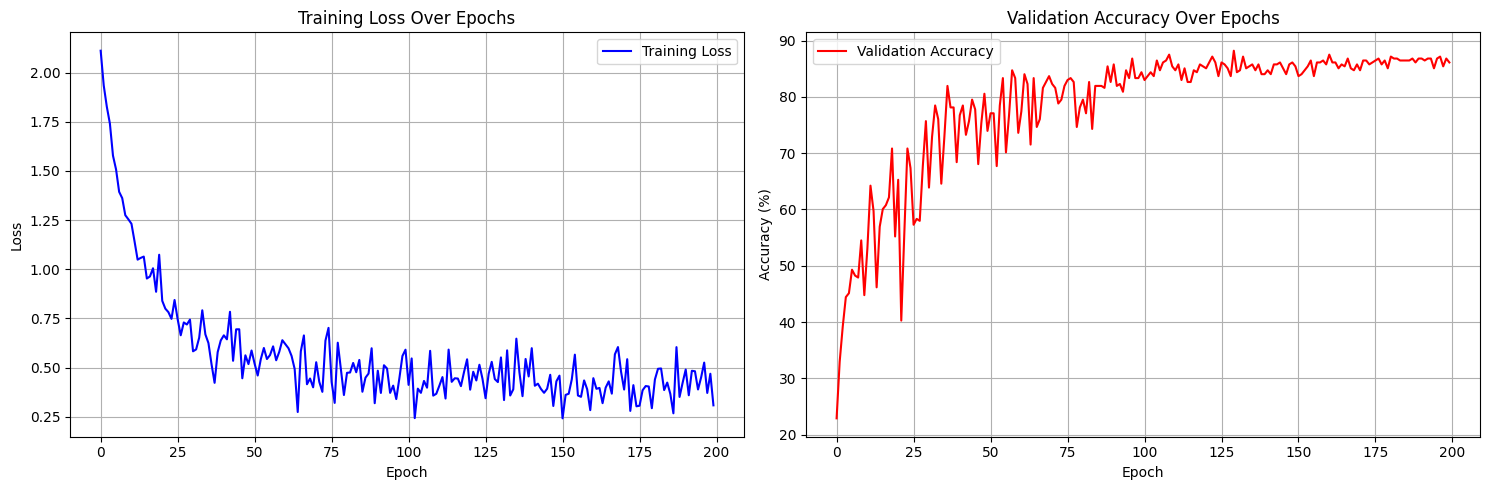


Final Results:
Best Validation Accuracy: 88.19%
Final Training Loss: 0.3080


In [8]:
# Plot training loss and validation accuracy
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Results:")
print(f"Best Validation Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")

## Confusion Matrix

The confusion matrix shows:
- Rows: True emotions
- Columns: Predicted emotions
- Numbers: Count of predictions
- Diagonal: Correct predictions
- Off-diagonal: Misclassifications

This helps identify which emotions are commonly confused with each other.

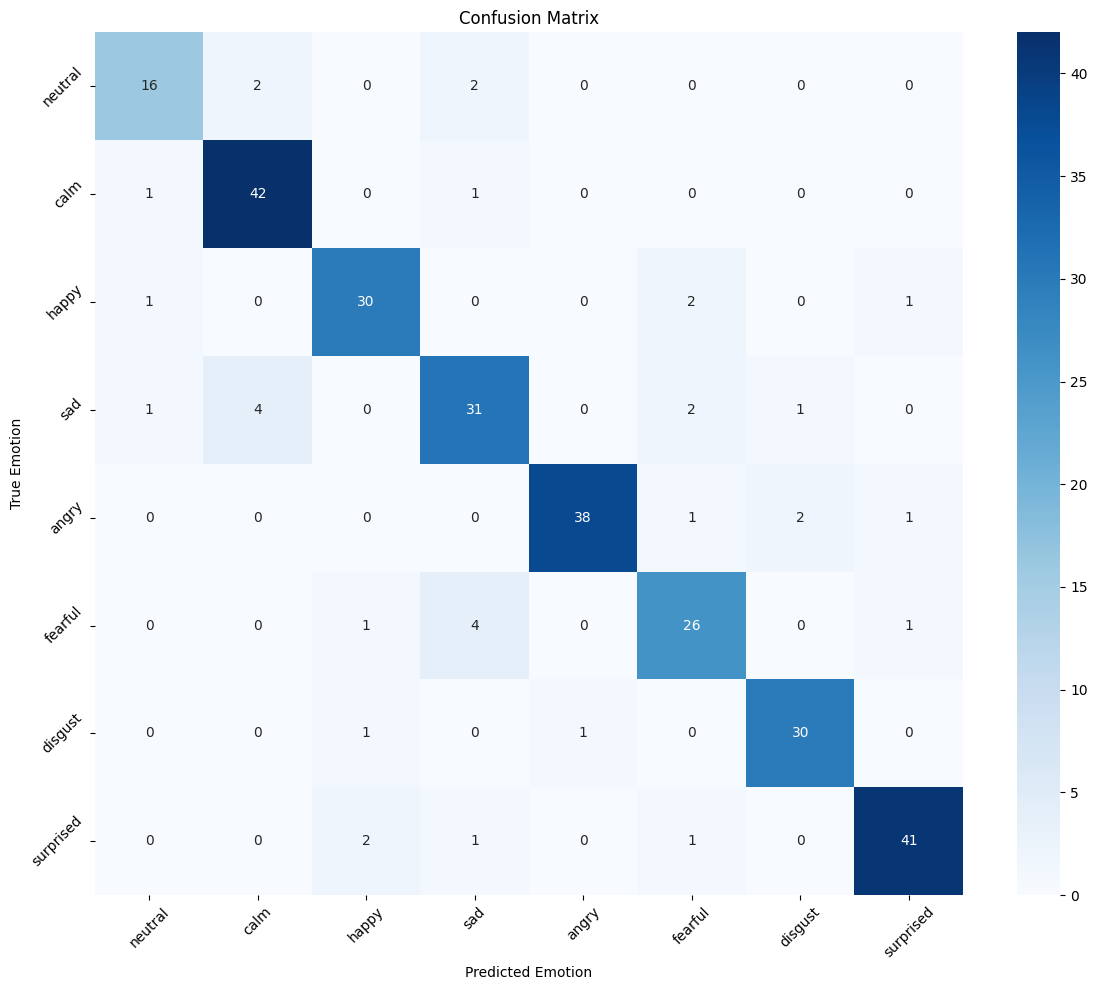


Confusion Matrix Analysis:
Total Correct Predictions: 254
Total Samples: 288
Overall Accuracy: 88.19%

Per-class Accuracy:
neutral: 80.00%
calm: 95.45%
happy: 88.24%
sad: 79.49%
angry: 90.48%
fearful: 81.25%
disgust: 93.75%
surprised: 91.11%


In [9]:
# Create and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(epoch_targets, epoch_predictions)

# Create confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print overall metrics
total_correct = np.sum(np.diag(cm))
total_samples = np.sum(cm)
print(f"\nConfusion Matrix Analysis:")
print(f"Total Correct Predictions: {total_correct}")
print(f"Total Samples: {total_samples}")
print(f"Overall Accuracy: {100 * total_correct / total_samples:.2f}%")

# Calculate per-class accuracy
print("\nPer-class Accuracy:")
for i, emotion in enumerate(emotion_labels):
    class_correct = cm[i, i]
    class_total = np.sum(cm[i, :])
    if class_total > 0:
        class_accuracy = 100 * class_correct / class_total
        print(f"{emotion}: {class_accuracy:.2f}%")